In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow==2.9.1

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


Stage 1

In [ ]:
#Read Data and Store it in a dataframe
# Generate data paths with labels
#Use your own dataset path in Google drive
data_dir = '/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
#EDA Q1:How is the data distribution
df.head(5)

,filepaths,labels
0,/content/gdrive/MyDrive/Capstone project/Shoe ...,Boot
1,/content/gdrive/MyDrive/Capstone project/Shoe ...,Boot
2,/content/gdrive/MyDrive/Capstone project/Shoe ...,Boot
3,/content/gdrive/MyDrive/Capstone project/Shoe ...,Boot
4,/content/gdrive/MyDrive/Capstone project/Shoe ...,Boot


In [ ]:
df.tail(5)

,filepaths,labels
6603,/content/gdrive/MyDrive/Capstone project/Shoe ...,Shoe
6604,/content/gdrive/MyDrive/Capstone project/Shoe ...,Shoe
6605,/content/gdrive/MyDrive/Capstone project/Shoe ...,Shoe
6606,/content/gdrive/MyDrive/Capstone project/Shoe ...,Shoe
6607,/content/gdrive/MyDrive/Capstone project/Shoe ...,Shoe


In [ ]:
#EDA Q2:Are there labels available for the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6608 entries, 0 to 6607
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  6608 non-null   object
 1   labels     6608 non-null   object
dtypes: object(2)
memory usage: 103.4+ KB


In [ ]:
#EDA 3: How much data can be used for training, validation and testing?
#Split dataframe into train, valid, and test
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# EDA Q4: Can we visualise the data?
#Create image data generator
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

Found 5286 validated image filenames belonging to 3 classes.
Found 793 validated image filenames belonging to 3 classes.
Found 529 validated image filenames belonging to 3 classes.


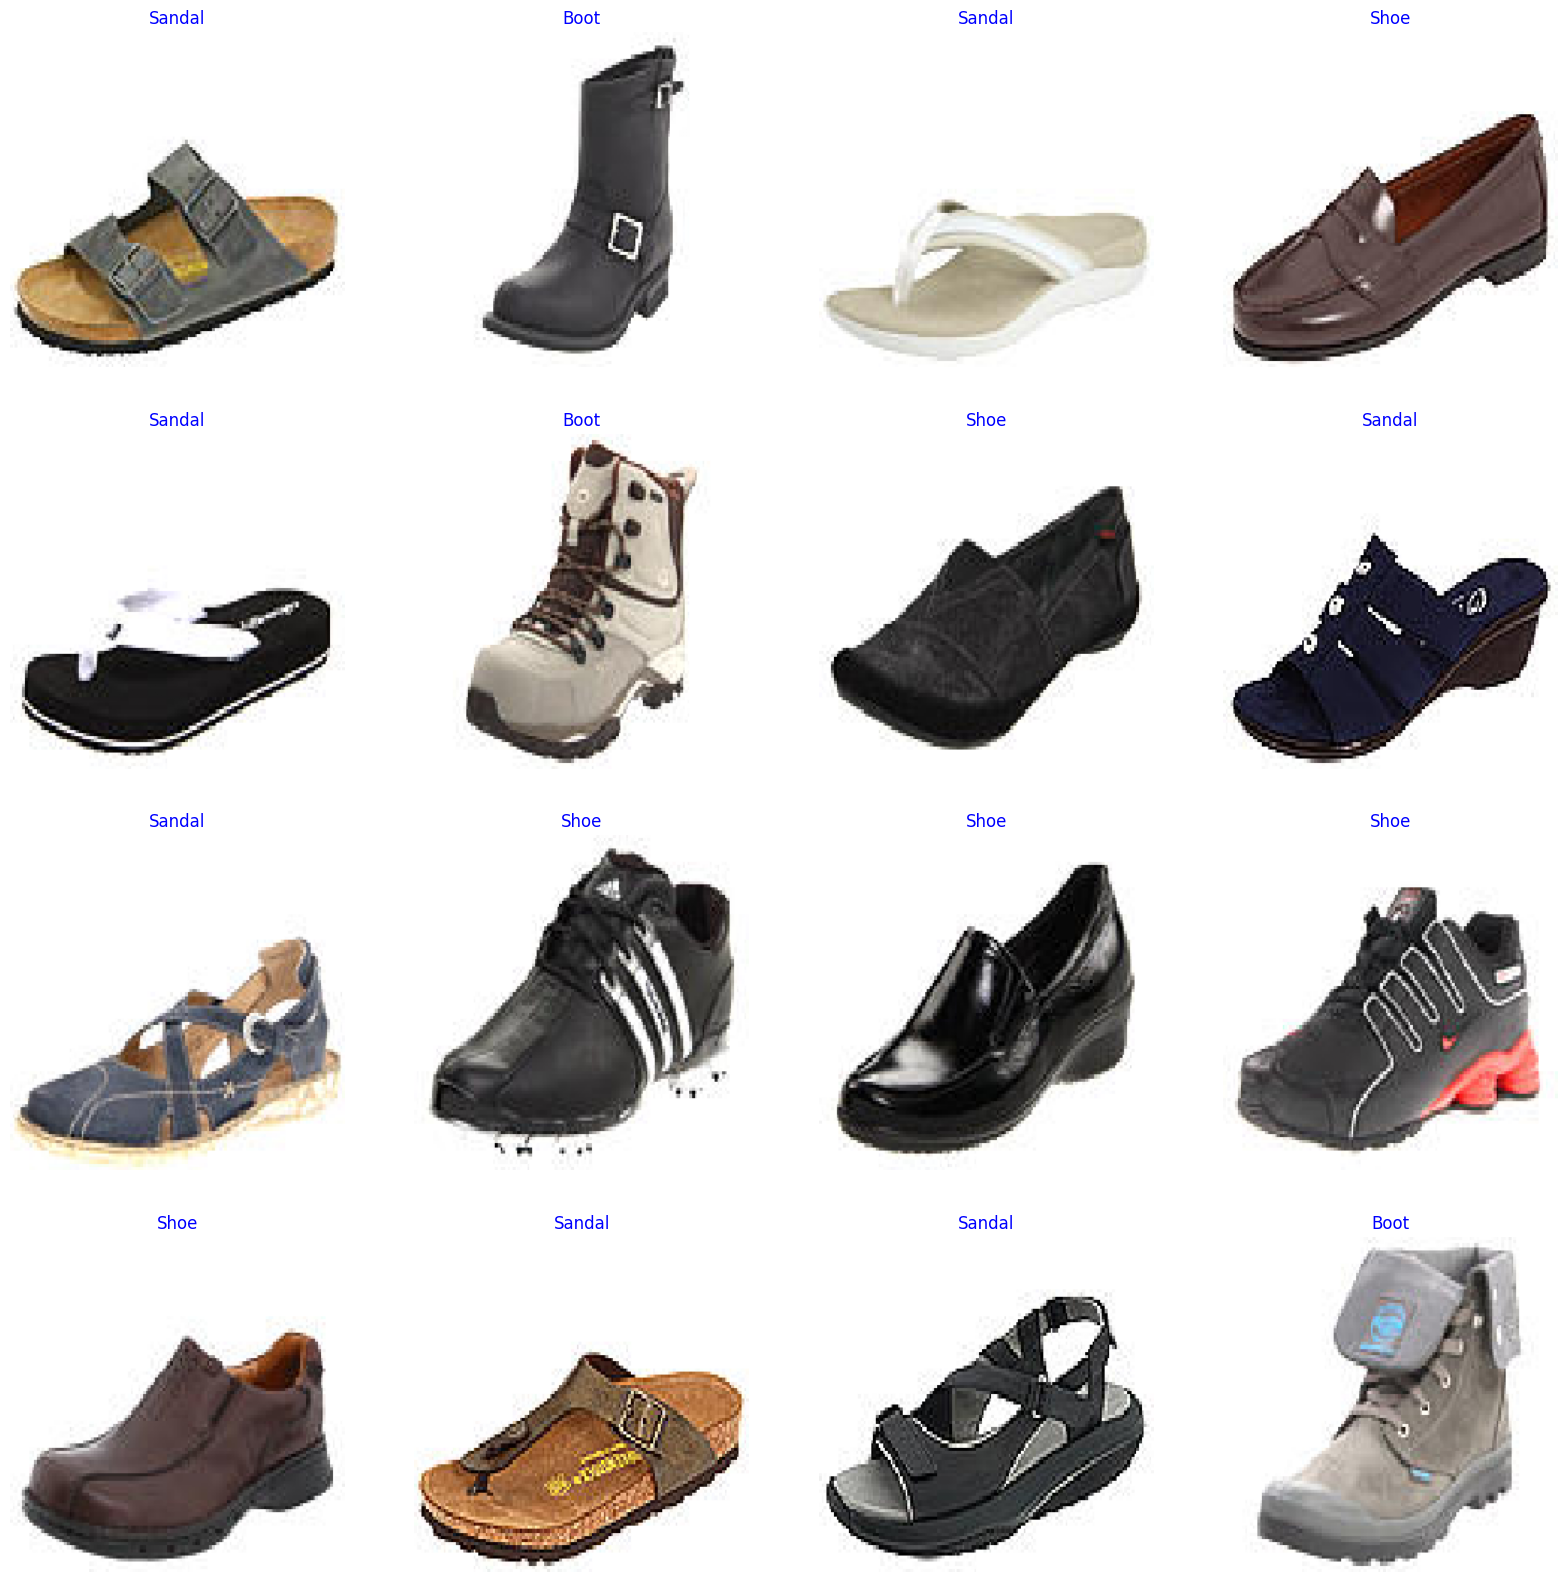

In [ ]:
#EDA Q5: How does the samples from the training subset look like ?

g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

Stage 3

In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/gdrive/MyDrive/Capstone project/converted_keras/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/gdrive/MyDrive/Capstone project/converted_keras/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 3s 3s/step
Class: boot
Confidence Score: 0.9999472


In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/gdrive/MyDrive/Capstone project/converted_keras/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/gdrive/MyDrive/Capstone project/converted_keras/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Boot/boot (1155).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 892ms/step
Class: boot
Confidence Score: 0.9999975


In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/gdrive/MyDrive/Capstone project/converted_keras/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/gdrive/MyDrive/Capstone project/converted_keras/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (1097).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 831ms/step
Class: sandal
Confidence Score: 0.9998946


In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/gdrive/MyDrive/Capstone project/converted_keras/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/gdrive/MyDrive/Capstone project/converted_keras/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1194).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 813ms/step
Class: shoe
Confidence Score: 0.95985484


In [ ]:
from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("/content/gdrive/MyDrive/Capstone project/converted_keras/keras_model.h5", compile=False)

# Load the labels
class_names = open("/content/gdrive/MyDrive/Capstone project/converted_keras/labels.txt", "r").readlines()

# Create the array of the right shape to feed into the keras model
# The 'length' or number of images you can put into the array is
# determined by the first position in the shape tuple, in this case 1
data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

# Replace this with the path to your image
image = Image.open("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1358).jpg").convert("RGB")

# resizing the image to be at least 224x224 and then cropping from the center
size = (224, 224)
image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

# turn the image into a numpy array
image_array = np.asarray(image)

# Normalize the image
normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

# Load the image into the array
data[0] = normalized_image_array

# Predicts the model
prediction = model.predict(data)
index = np.argmax(prediction)
class_name = class_names[index]
confidence_score = prediction[0][index]

# Print prediction and confidence score
print("Class:", class_name[2:], end="")
print("Confidence Score:", confidence_score)


1/1 [==============================] - 1s 796ms/step
Class: sandal
Confidence Score: 0.9331367


<dtype: 'uint8'>


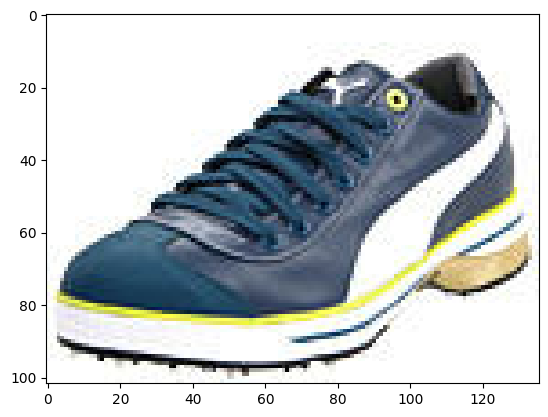

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/drive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1004).jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

<dtype: 'uint8'>


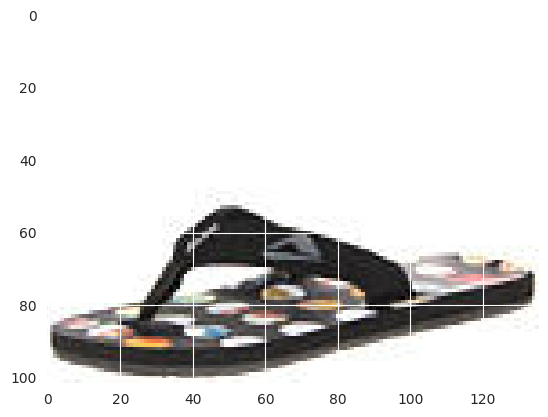

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (1075).jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

<dtype: 'uint8'>


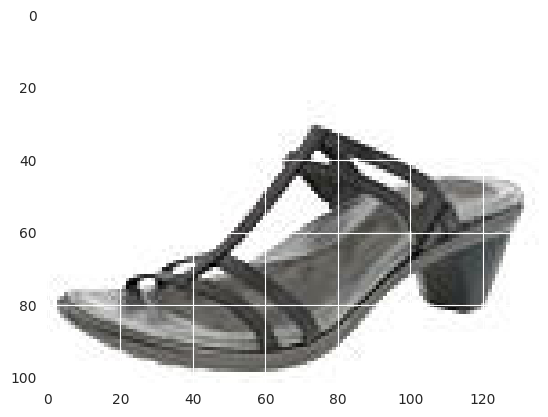

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Sandal/Sandal (1138).jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

<dtype: 'uint8'>


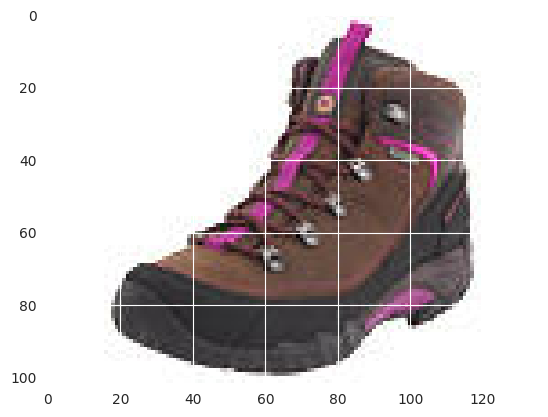

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Boot/boot (1043).jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()

<dtype: 'uint8'>


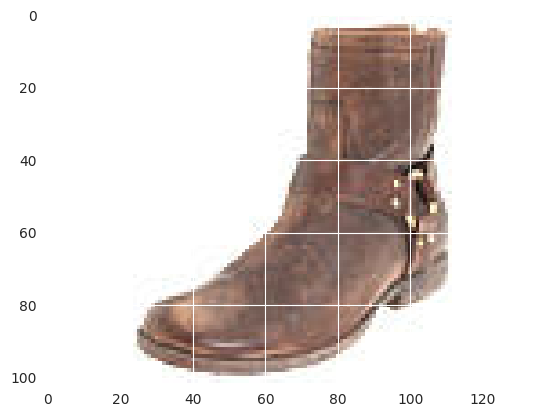

In [ ]:
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt

filterwarnings("ignore")
tf_img = io.read_file("/content/gdrive/MyDrive/Capstone project/Shoe vs Sandal vs Boot Dataset/Boot/boot (1150).jpg")
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)
# plt.show()